# Dry Beans Classification With Supervised Learning


IART 2020/2021  - T4G4

Breno Accioly   - up201800170@edu.fe.up.pt

Ivo Saavedra    - up201707093@edu.fe.up.pt

Rodrigo Reis    - up201806534@edu.fe.up.pt

## Introduction

The main objective of this project was to create a classification model apllying multiple Supervised Learning algorithms to the given dataset.

On this notebook we report the necessary steps taken to process the input data as well as implemented algorithms and their parameters. We will also compare the classification models in order to determine which ones are the most appropriate for the problem at hand.

## Problem Description

The provided dataset contains seven target classes:  
    - **Seker:** large and round seeds;  
    - **Barbunya:** large seeds with an oval shape;  
    - **Bombay:** very large seeds with oval shape;  
    - **Cali:** large kidney shapped seeds;  
    - **Horoz:** long, cylindrical and medium size;  
    - **Sira:** small nad flat seeds;  
    - **Dermason:** flat beans with round endings.  
    
The features used to evaluate each bean are the following:  
    - **Area (A):** Area of a bean zone and the number of pixels within its boundaries;  
    - **Perimeter (P):** Bean circumference is defined as the length of its border;  
    - **Major axis length (L):** Distance between the ends of the longest line that can be drawn from a bean;  
    - **Minor axis length (l):** Longest line that can be drawn from the bean while standing perpendicular to the main axis.  
    - **Aspect ratio (K):** Relationship between L and l.  
    - **Eccentricity (Ec):** Eccentricity of the ellipse having the same moments as the region.  
    - **Convex area (C):** Number of pixels in the smallest convex polygon that can contain the area of a bean seed.  
    - **Equivalent diameter (Ed):** Diameter of a circle having the same area as a bean seed area.  
    - **Extent (Ex):** Ratio of the pixels in the bounding box to the bean area.  
    - **Solidity (S):** Ratio of the pixels in the convex shell to those found in beans (convexity).  
    - **Roundness (R):** Calculated with the following formula: (4piA)/(P^2)  
    - **Compactness (CO):** Measures the roundness of an object: Ed/L  
    - **Shape Factor(1-4):** Shape features used to classify each bean

## Code

In this section we will explain each of the steps taken to analyse and process the provided dataset.    

### Imported Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pandas as pd
from matplotlib.colors import ListedColormap
from math import ceil, sqrt

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix, classification_report, f1_score
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import neighbors, datasets
from sklearn.model_selection import StratifiedShuffleSplit

### Helper Functions

In [12]:
# plots a data distribution bar chart
def plot_bar_distribution(data):

    plt.figure(figsize=(14, 10))
    # Extracting class lables
    classes = pd.unique(beans_data.iloc[:, -1])
    percent = [(data['Class'] == c).sum()/len(data) for c in classes]
    
    dic = { "Class" : [c for c in classes], "Percentage" : [p for p in percent]}
    df = pd.DataFrame (dic, columns = ['Class','Percentage'])
    
    ax = sb.barplot(x="Class", y="Percentage", data=df)
    plt.show()

# plots data from a single class
def plot_class_data(ds, class_name, out_file, out_dir='./output/'):
    data = ds.loc[ds['Class'] == f'{class_name}']
    sb.pairplot(data.dropna(), hue='Class')
    plt.savefig(f'{out_dir}{out_file}.png')

# creates the violin plots from the given columns
def violin_plot(data, columns, out_file, out_dir='./output/'):
    plt.figure(figsize=(14, 10))

    if len(columns) == 0: 
        columns = data.columns
    
    plot_cols = ceil(sqrt(len(columns)))
    plot_rows = max(1, ceil(len(columns)/plot_cols))

    tmp = data[:]
    
    for column_index, column in enumerate(columns):
        tmp[column] = tmp[column].astype(float)
        if column=='Class':
            continue
        plt.subplot(plot_rows, plot_cols, column_index + 1)
        sb.violinplot(x='Class', y=column, data=tmp)
    plt.plot()

# plots a bar chart with the f1-scores obtained for each class
def compare_class_results(reports, model_names):
    dic = { 'Model' : [], 'Class' : [], 'Score':[]}
    
    # extracting relevant data from each model report
    for modelName, rep in zip(model_names, reports): 
        for i, (key, values) in enumerate(rep.items()):
            if (i > 6):
                break;
            dic['Model'].append(modelName)
            dic['Class'].append(key)
            dic['Score'].append(values["f1-score"])
      
    df = pd.DataFrame (dic, columns = ['Model','Class', 'Score'])
    
    plt.figure(figsize=(14,10))
    sb.barplot(x='Class', y='Score', hue='Model', data=df)
    plt.legend(title="Classifier", bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
    plt.ylabel("F1-Score", size=14)
    plt.xlabel("Bean Class", size=14)
    plt.title("Score Analysis By Class", size=18)
    plt.show()

# plots a bar chart with the weighted f1-scores of the classification models
def compare_overall_results(reports, model_names):
    dic = { 'Model' : [], 'Score':[]}
    
    # extracting relevant data from each model report
    for modelName, rep in zip(model_names, reports): 
        dic['Model'].append(modelName)
        dic['Score'].append(rep['weighted avg']["f1-score"])
      
    df = pd.DataFrame (dic, columns = ['Model','Score'])
    
    plt.figure(figsize=(14,10))
    sb.barplot(x='Model', y='Score', data=df)
    # plt.legend(title="Classifier", bbox_to_anchor=(1.05, 0.6), loc=2, borderaxespad=0.)
    plt.ylabel("Weighted F1-Score", size=14)
    plt.xlabel("Classifier", size=14)
    plt.title("Classifier Weighted F1-Score Analysis", size=18)
    plt.show()

### Loading and Analysing the Dataset

We started by reading the provided dataset and assering the existence of empty cells, which there were none.  
Then we noticed that the 'roundness' column was the only one that started with a lowercase letter so we rectified this.

In [3]:
beans_data = pd.read_excel('../resources/dataset.xlsx', na_values=['NA'], engine='openpyxl')

# null values verification
n = beans_data.isnull().sum().sum()
if n > 0:
    print(f'[!] {n} values are missing.')

# renaming 'roundness' column to be consistent with the other columns
beans_data.rename(columns = {'roundness' : 'Roundness'}, inplace=True)

# A first look at the dataset's features.
beans_data.describe()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,Roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
count,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000,13611.000000
mean,53048.284549,855.283459,320.141867,202.270714,1.583242,0.750895,53768.200206,253.064220,0.749733,0.987143,0.873282,0.799864,0.006564,0.001716,0.643590,0.995063
std,29324.095717,214.289696,85.694186,44.970091,0.246678,0.092002,29774.915817,59.177120,0.049086,0.004660,0.059520,0.061713,0.001128,0.000596,0.098996,0.004366
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36328.000000,703.523500,253.303633,175.848170,1.432307,0.715928,36714.500000,215.068003,0.718634,0.985670,0.832096,0.762469,0.005900,0.001154,0.581359,0.993703
50%,44652.000000,794.941000,296.883367,192.431733,1.551124,0.764441,45178.000000,238.438026,0.759859,0.988283,0.883157,0.801277,0.006645,0.001694,0.642044,0.996386
75%,61332.000000,977.213000,376.495012,217.031741,1.707109,0.810466,62294.000000,279.446467,0.786851,0.990013,0.916869,0.834270,0.007271,0.002170,0.696006,0.997883
max,254616.000000,1985.370000,738.860153,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


Ploting the the data distribution of the original dataset.

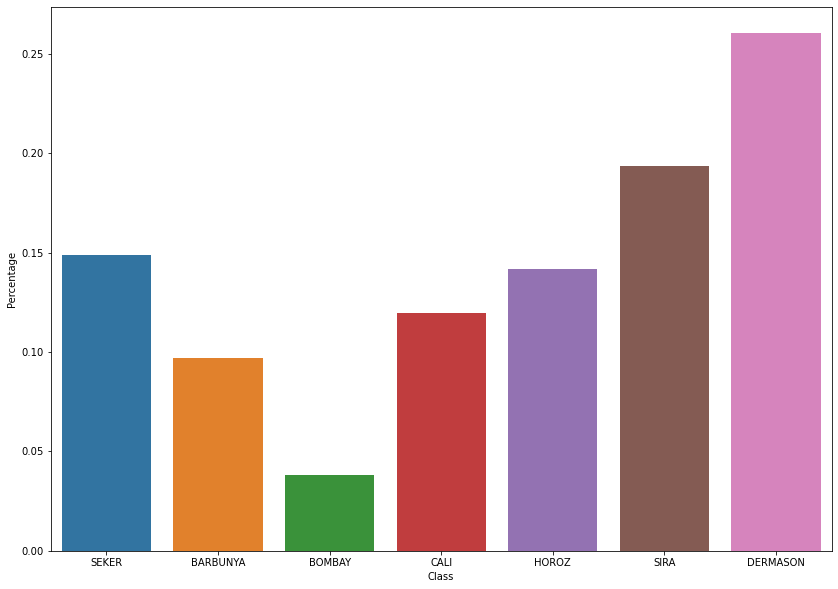

In [5]:
plot_bar_distribution(beans_data)

We generated a **scatterplot matrix** from the original dataset (not including code here, because it would be too slow).  
After some analysis we could easily identify most outliers which needed to be removed, because they would impact our classification models in a negative way.

![Scatter Plot](images/out.png)

### Removing outliers and Preparing final Dataset

In order to identify the outliers of each class we created an auxiliary function to only plot each class's data.
We also create an auxiliary dataframe in order to save any changes made on the original one, thus preserving the provided dataset.

Here is an example of the outliers we identified for the 'SEKER' class.  
  
![SEKER Solidity Outlier](images/seker_solidity_outlier.png)
![SEKER Solidity Outlier](images/seker_shapefactor4_outlier.png)  

For each bean class we analysed the generated scatterplot matrix and identified their outliers.




In [6]:
# final data frame (after removal of outliers)
beans_data.columns.insert(0, 'id')
final_data = pd.DataFrame(columns=beans_data.columns)

# removing 'Seker' outliers
seker_data = beans_data.loc[ (beans_data['Class'] == 'SEKER') & (beans_data['Solidity'] >= 0.96) & (beans_data['ShapeFactor4'] >= 0.98) ]
final_data = final_data.append(seker_data)

# removing 'Barbunya' outliers
barb_data = beans_data.loc[ (beans_data['Class'] == 'BARBUNYA') &  (beans_data['MinorAxisLength'] < 325)]
final_data = final_data.append(barb_data)

# removing 'Bombay' outliers
bombay_data = beans_data.loc[ (beans_data['Class'] == 'BOMBAY') &  (beans_data['ShapeFactor2'] < 0.0014)]
final_data = final_data.append(bombay_data)

# removing 'Cali' outliers
cali_data = beans_data.loc[ (beans_data['Class'] == 'CALI') &  (beans_data['Area'] < 110000) & (beans_data['Eccentricity'] > 0.70) & (beans_data['MinorAxisLength'] > 185) ]
final_data = final_data.append(cali_data)

#removing 'Horoz' outliers
horoz_data = beans_data.loc[ (beans_data['Class'] == 'HOROZ') &  (beans_data['Area'] < 80000)  & (beans_data['ConvexArea'] < 80000) & (beans_data['EquivDiameter'] < 320)]
final_data = final_data.append(horoz_data)

# removing 'Sira' outliers
sira_data = beans_data.loc[ (beans_data['Class'] == 'SIRA') &  (beans_data['Area'] < 63000) & (beans_data['Roundness'] > 0.59)] 
final_data = final_data.append(sira_data)

#removing 'Dermason' outliers
derma_data = beans_data.loc[ (beans_data['Class'] == 'DERMASON') &  (beans_data['Perimeter'] < 850) & (beans_data['Roundness'] > 0.59)] 
final_data = final_data.append(derma_data)

In order to better understand the distribution of features and to spot aditional outliers we created violin plots from the processed dataset for each feature.

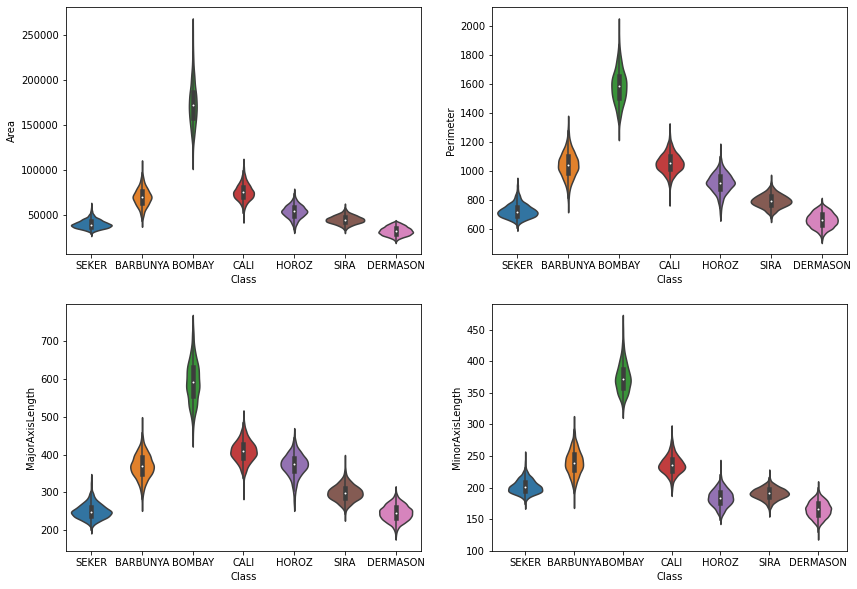

In [22]:
violin_plot(final_data, ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength'], 'violin_')

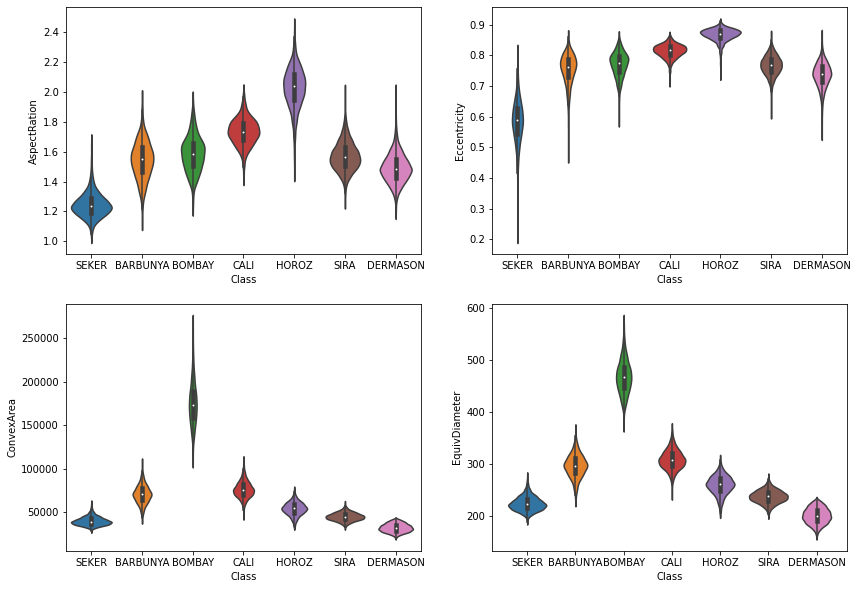

In [24]:
violin_plot(final_data, ['AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter'], 'violin_')

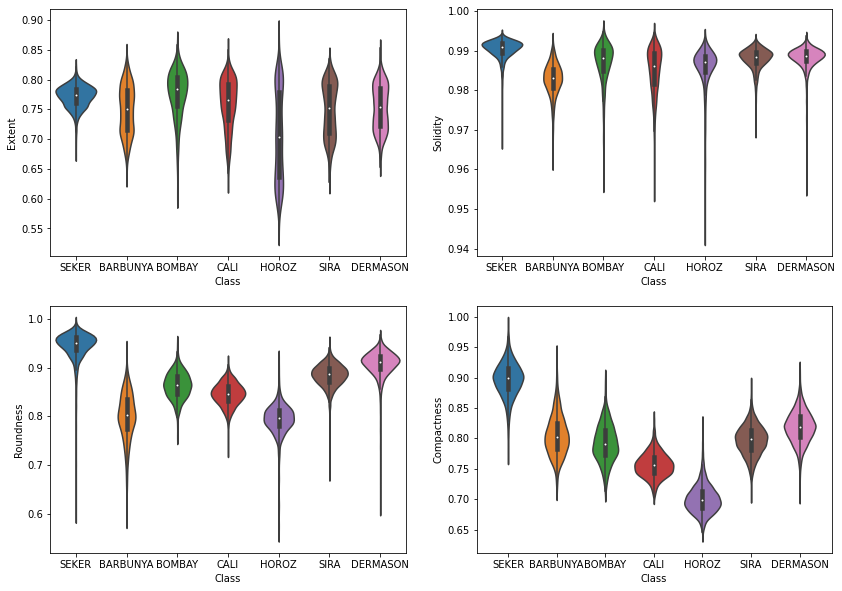

In [27]:
violin_plot(final_data, ['Extent', 'Solidity', 'Roundness', 'Compactness'], 'violin_')

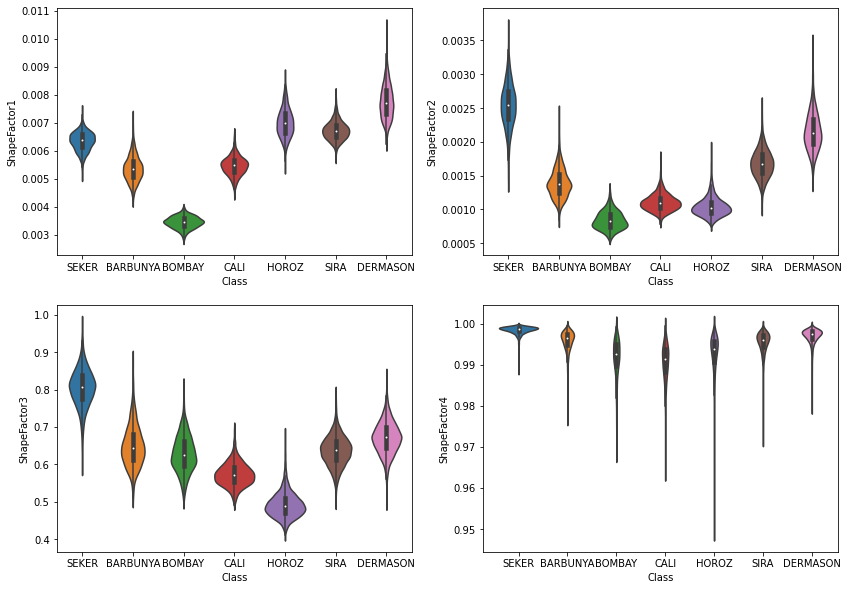

In [29]:
violin_plot(final_data, ['ShapeFactor1', 'ShapeFactor2', 'ShapeFactor3', 'ShapeFactor4'], 'violin_shapefactors')

## Algorithms

This section contains all the implemented algorithms for this assignment.
Firstly, we extracted the dataset's values and target columns into two dataframes. We then proportionaly split the two sets into training and testing sets with the **StratifiedShuffleSplit** module.  
As there are seven different classes and each one has a different number of rows we resorted to the **f1_score** function with a **weighted** average.

In [7]:
# extract values and class labels
X, y = np.array(final_data.iloc[:, :-1]), np.array(final_data.iloc[:, -1])

# split values into testing and training datasets
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, train_size=0.8, random_state=0)

for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

### Decision Tree

              precision    recall  f1-score   support

    BARBUNYA       0.95      0.91      0.93       264
      BOMBAY       1.00      0.99      1.00       104
        CALI       0.96      0.96      0.96       325
    DERMASON       0.96      0.95      0.96       709
       HOROZ       0.96      0.98      0.97       386
       SEKER       0.97      0.96      0.96       405
        SIRA       0.92      0.95      0.93       527

    accuracy                           0.95      2720
   macro avg       0.96      0.96      0.96      2720
weighted avg       0.95      0.95      0.95      2720

F1 Score:  0.9540720530035739


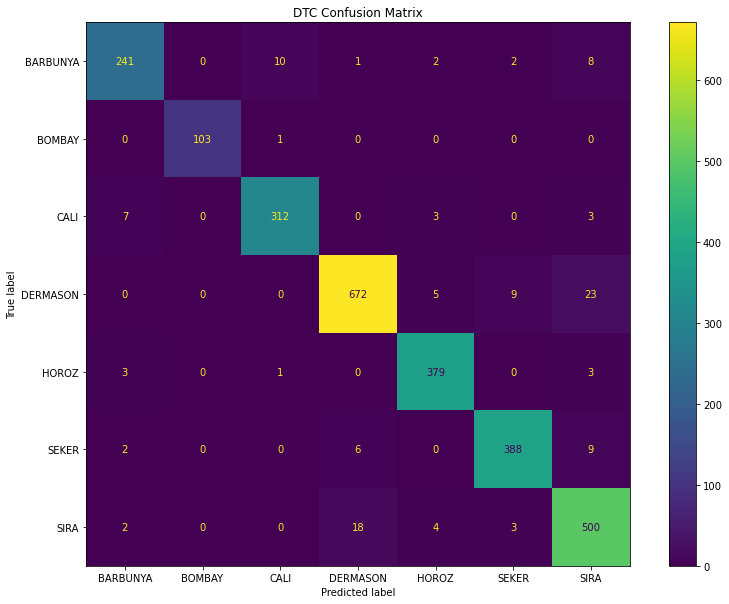

In [14]:
def dtc(X_train, X_test, y_train, y_test):
    clf = tree.DecisionTreeClassifier(max_depth=10, min_samples_leaf=5)
    clf = clf.fit(X_test, y_test)
       
    # generate predictions
    predictions = clf.predict(X_test)  
    print(classification_report(y_test, predictions))  
    
    # save classification report
    report = classification_report(y_test, predictions, output_dict=True)
    print("F1 Score: ", report['weighted avg']['f1-score'])
    
    # show confusion matrix
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax).ax_.set_title('DTC Confusion Matrix')
    plt.show()
    
    return report
dtc_report = dtc(X_train, X_test, y_train, y_test)

### Neural Network - Multi-layer Perceptron

We used the 'adam' solver as it was more suitable for large datasets, however we were also able to obtain good results with the 'sgd' solver. Before making any predictions we applied a **StandardScaler**, so every feature can be evaluated uniformly.  
In order to assert which combination of parameters originated better results we ran the following grid search:

In [10]:
def neural_params_search(X, y):
    scaler = StandardScaler()
    scaler.fit(X)

    X_train = scaler.transform(X)
    # Evaluates and searches for the best mlp parameters
    params = {
                'solver': ['adam', 'sgd'], 
                'alpha': [0.0001, 0.05], 
                'hidden_layer_sizes': [8, 9, 10, 11, 12], 
                'max_iter': [300, 500]
            }
    grid = GridSearchCV(MLPClassifier(), params, scoring='f1_weighted', refit=True, verbose=0, n_jobs=2)
    grid.fit(X_train, y)
    print(grid.best_estimator_)
    print(grid.best_params_)
    
neural_params_search(X_train, y_train)

              precision    recall  f1-score   support

    BARBUNYA       0.96      0.86      0.91       264
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.97      0.95       325
    DERMASON       0.94      0.93      0.93       709
       HOROZ       0.97      0.96      0.96       386
       SEKER       0.95      0.96      0.95       405
        SIRA       0.87      0.90      0.88       527

    accuracy                           0.93      2720
   macro avg       0.94      0.94      0.94      2720
weighted avg       0.93      0.93      0.93      2720

F1 Score:  0.9331029588636832


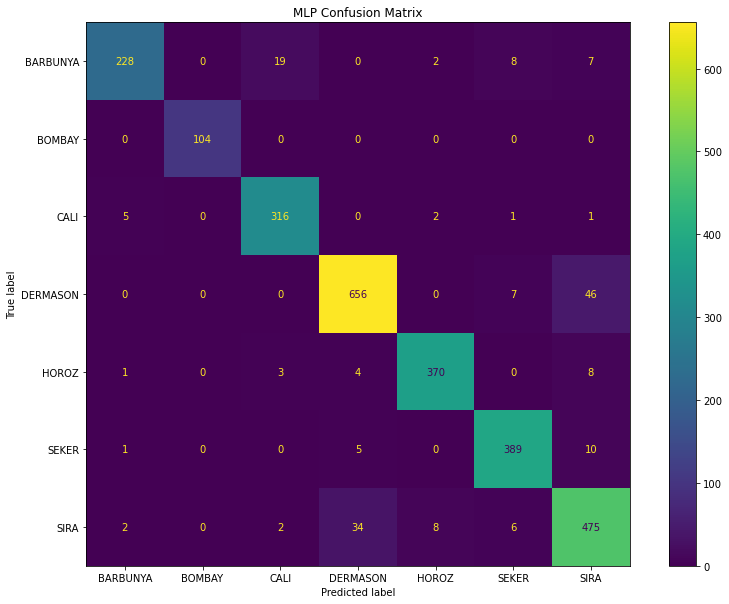

In [15]:
def neural(X_train, X_test, y_train, y_test):
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    
    clf = MLPClassifier(solver='adam', alpha=0.001, hidden_layer_sizes=11, max_iter=400)
    clf.fit(X_train, y_train)
   
    # generate predictions
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    
    # save classification report
    report = classification_report(y_test, predictions, output_dict=True)
    print("F1 Score: ", report['weighted avg']['f1-score'])
    
    # show confusion matrix
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax).ax_.set_title('MLP Confusion Matrix')
    plt.show()
    
    return report

# invoke classifier
neural_report = neural(X_train, X_test, y_train, y_test)

### Support Vector Classification
The support vector machine algorithm tries to identify a hyperplane(decision boundary) that differentiates two or more classes.
It is possible to classify non-linear problems, making use of kernels, which are functions that converts the non-linear data to linear.
We were able to get good results with the **linear** and **rbf**(radial basis function) kernels.

This algorithm needs two majors parameters, **Gamma**, which is used in the rbf kernel and defines how far the influence of a single training example reaches, and **C**, which is the penalty of misclassifying the data in the learning process.

kernel used:  rbf
              precision    recall  f1-score   support

    BARBUNYA       0.95      0.85      0.90       264
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.98      0.95       325
    DERMASON       0.93      0.93      0.93       709
       HOROZ       0.97      0.96      0.96       386
       SEKER       0.95      0.94      0.95       405
        SIRA       0.86      0.90      0.88       527

    accuracy                           0.93      2720
   macro avg       0.94      0.94      0.94      2720
weighted avg       0.93      0.93      0.93      2720

F1 Score:  0.9305097459659093


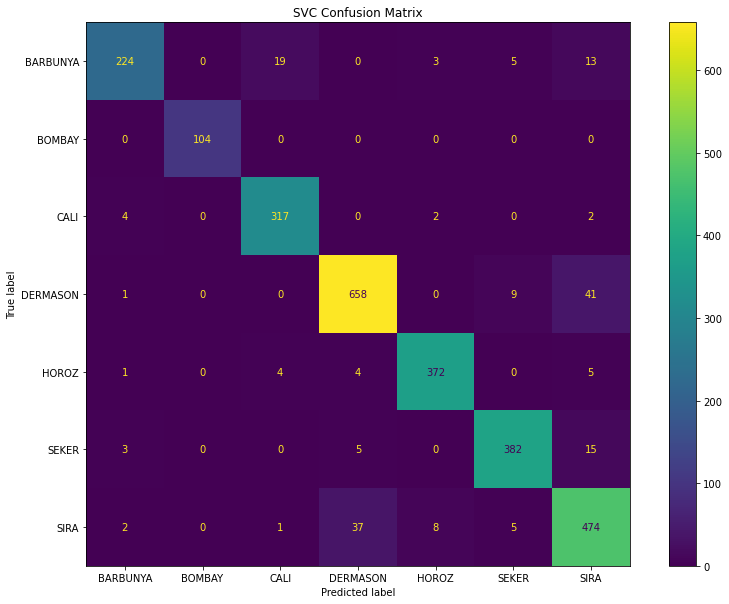

In [16]:
def svc(X_train, X_test, y_train, y_test, kernel="linear"):
    print("kernel used: ", kernel)
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    clf = svm.SVC(kernel=kernel, cache_size=500, C=10, gamma=0.001)
    clf.fit(X_train, y_train)
    
    # generate predictions
    predictions = clf.predict(X_test)
    print(classification_report(y_test, predictions))
    
    # save classification report
    report = classification_report(y_test, predictions, output_dict=True)
    print("F1 Score: ", report['weighted avg']['f1-score'])
    
    # show confusion matrix
    fig, ax = plt.subplots(figsize=(14, 10))
    plot_confusion_matrix(clf, X_test, y_test, ax=ax).ax_.set_title('SVC Confusion Matrix')
    plt.show()
    
    return report

svc_report = svc(X_train, X_test, y_train, y_test, "rbf")

### K-Nearest Neighbors

              precision    recall  f1-score   support

    BARBUNYA       0.94      0.87      0.90       264
      BOMBAY       1.00      1.00      1.00       104
        CALI       0.93      0.96      0.94       325
    DERMASON       0.91      0.94      0.93       709
       HOROZ       0.97      0.96      0.96       386
       SEKER       0.96      0.94      0.95       405
        SIRA       0.88      0.87      0.87       527

    accuracy                           0.93      2720
   macro avg       0.94      0.93      0.94      2720
weighted avg       0.93      0.93      0.93      2720

F1 Score:  0.9267288612579788


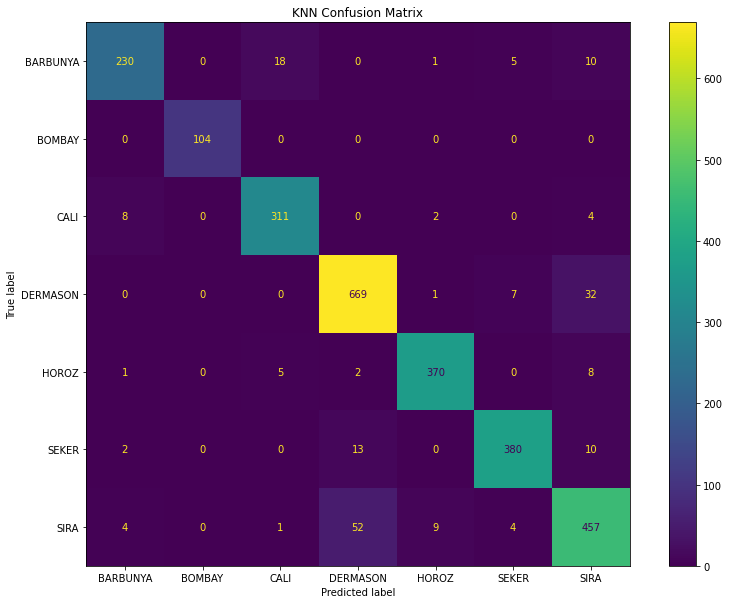

In [17]:
def knn(X_train, X_test, y_train, y_test):

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    neigh = KNeighborsClassifier(n_neighbors=6, leaf_size=50)
    neigh.fit(X_train, y_train)

    predictions = neigh.predict(X_test)
    print(classification_report(y_test, predictions))

    
    report = classification_report(y_test, predictions, output_dict=True)
    print("F1 Score: ", report['weighted avg']['f1-score'])


    fig, ax = plt.subplots(figsize=(14, 10))
    plot_confusion_matrix(neigh, X_test, y_test, ax=ax).ax_.set_title('KNN Confusion Matrix')
    plt.show()

    return report

knn_report = knn(X_train, X_test, y_train, y_test)

## Classification Model Comparison

In order to analyse the results obtained for each model we plotted two charts. The first is a comparison of the f1-scores obtained for each target label with the diferent models. The other chart describes the overall score obtained by each of the classification models. For this we used the f1-score function with a weighted average as it takes into consideration the amount of entries for each bean class.


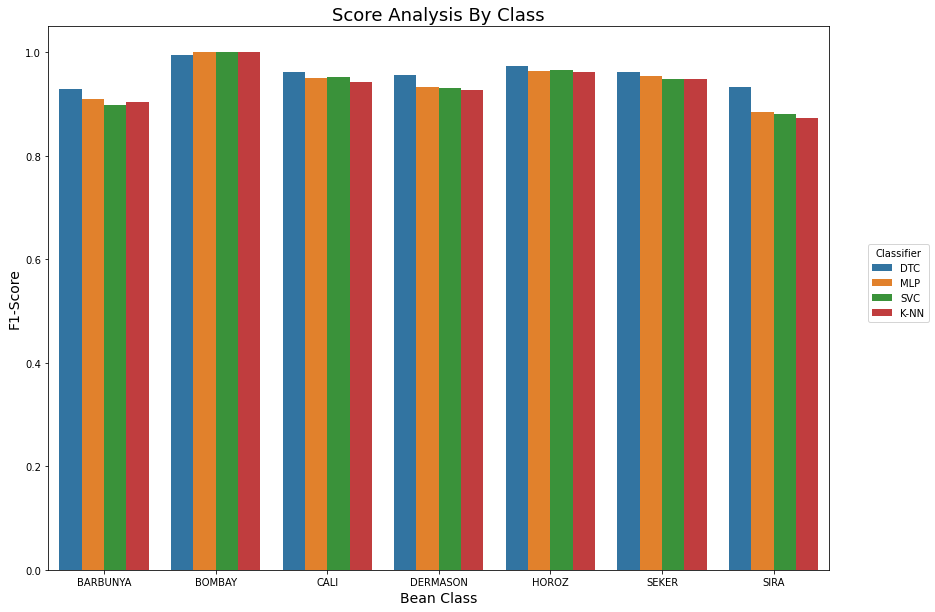

In [18]:
compare_class_results([dtc_report, neural_report, svc_report, knn_report], ['DTC', 'MLP', 'SVC', 'K-NN'] )

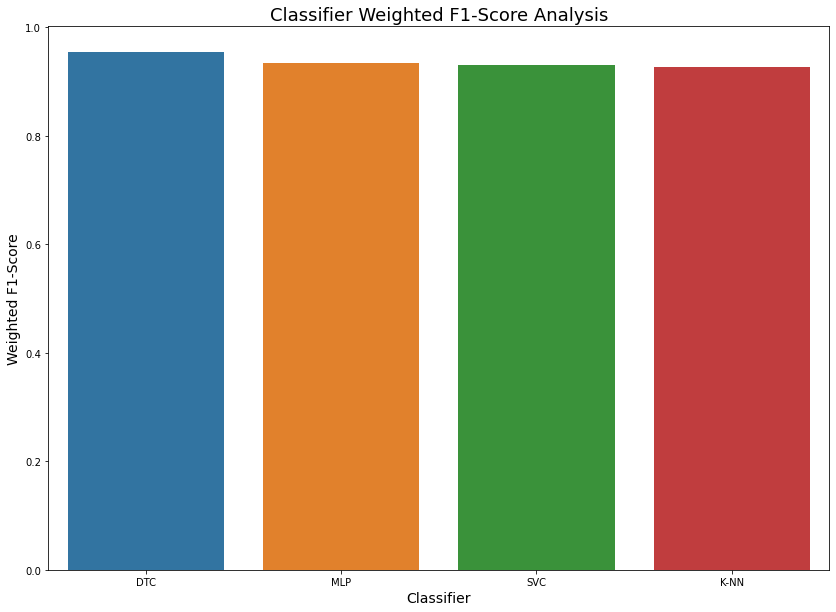

In [19]:
compare_overall_results([dtc_report, neural_report, svc_report, knn_report], ['DTC', 'MLP', 'SVC', 'K-NN'])